In [143]:
import math
from glob import glob
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from category_encoders import OneHotEncoder
from joblib import dump, load
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
# from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (ElasticNetCV, LassoCV, LinearRegression,
                                  RidgeCV)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from xgboost import XGBRegressor


In [144]:
sns.set_theme(style="whitegrid", font="Verdana")

In [145]:
%matplotlib inline


# Functions

In [146]:
def show_linear_metrics(y_true: np.array, y_pred: np.array) -> None:
    """Prints linear metrics.

    Parameters
    ----------
    y_true : np.array
        y true
    y_pred : np.array
        y predicted
    """
    print("Mean Absolute Error:", mean_absolute_error(y_true=y_true, y_pred=y_pred))
    print("Mean Squared Error:", mean_squared_error(y_true=y_true, y_pred=y_pred))
    print(
        "Root Mean Squared Error:",
        mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False),
    )
    print("R^2 Score:", r2_score(y_true=y_true, y_pred=y_pred))


# [Dataset](https://drive.google.com/drive/folders/1nfrYxDm7TLzls9pedZbLX5rP4McVDWDe)

In [175]:
DATASET_PATH = "SSD2022AS2"


In [176]:
csv_files = glob(pathname=path.join(DATASET_PATH, "*.csv"), recursive=True)


In [177]:
dfs = list()

for csv_file in csv_files:
    dfs.append(pd.read_csv(filepath_or_buffer=csv_file))

df = pd.concat(objs=dfs, ignore_index=True)


In [178]:
df.timestamp = pd.to_datetime(arg=df.timestamp)


# Pipeline

In [196]:
df_ = df.copy()


In [197]:
df_ = df_.groupby(by=["client_user_id"]).aggregate(
    num_sessions=pd.NamedAgg(column="session_id", aggfunc=np.count_nonzero),
    avg_dropped_frames=pd.NamedAgg(column="dropped_frames", aggfunc=np.mean),
    avg_fps=pd.NamedAgg(column="FPS", aggfunc=np.mean),
    std_fps=pd.NamedAgg(column="FPS", aggfunc=np.std),
    avg_bitrate=pd.NamedAgg(column="bitrate", aggfunc=np.mean),
    std_bitrate=pd.NamedAgg(column="bitrate", aggfunc=np.std),
    avg_rtt=pd.NamedAgg(column="RTT", aggfunc=np.mean),
    std_rtt=pd.NamedAgg(column="RTT", aggfunc=np.std),
    devices=pd.NamedAgg(column="device", aggfunc=lambda x: ", ".join(x.unique())),
    windows_entry=pd.NamedAgg(
        column="device", aggfunc=lambda x: np.sum(x == "Windows")
    ),
    mac_entry=pd.NamedAgg(column="device", aggfunc=lambda x: np.sum(x == "Mac")),
    android_entry=pd.NamedAgg(
        column="device", aggfunc=lambda x: np.sum(x == "Android")
    ),
    total_hours=pd.NamedAgg(column="timestamp", aggfunc=lambda x: np.ptp(x).total_seconds() / 3600),
    last_session=pd.NamedAgg(column="timestamp", aggfunc=np.max),
    first_session=pd.NamedAgg(column="timestamp", aggfunc=np.min),
    # stream_quality=pd.NamedAgg(column="", aggfunc=""),
    # next_session=pd.NamedAgg(column="", aggfunc=""),
    # {
    #     "session_id": [np.count_nonzero],
    #     "dropped_frames": [np.mean],
    #     "FPS": [np.mean, np.std],
    #     "bitrate": [np.mean, np.std],
    #     "RTT": [np.mean, np.std],
    #     "timestamp": [np.min, np.max, np.ptp],
    #     "device": [pd.value_counts],
    # },
    # as_index=False,
)

df_["stream_quality"] = 0.0
df_["next_session"] = 0.0

df_ = df_.reset_index()


In [186]:
df_.columns = ["_".join(column).lower() for column in df_.columns.to_flat_index()]

df_ = df_.reset_index()


In [187]:
df_


,client_user_id,session_id_count_nonzero,dropped_frames_mean,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_amin,timestamp_amax,timestamp_ptp,device_value_counts
0,003c2e7e-4392-4d01-81bb-93f2cce29f0b,228,9.166667,44.337719,18.079243,3883.149123,5381.456809,171.109649,277.138638,2022-09-11 22:59:10,2022-09-11 23:18:05,0 days 00:18:55,228
1,004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a,870,0.510345,41.864368,12.710460,6415.157471,4366.984310,27.934483,11.900105,2022-09-13 17:01:15,2022-09-13 18:13:50,0 days 01:12:35,870
2,006e829c-f656-4836-bc04-bafec3901fdc,2585,1.278143,33.093230,7.385675,11537.770986,7436.004830,52.434429,37.828781,2022-09-06 12:31:15,2022-09-20 22:50:05,14 days 10:18:50,"[2316, 269]"
3,0085ad73-5bcb-4689-ba07-b6ce00b36a8d,1367,0.000000,28.529627,1.693271,8393.614484,3201.918989,37.773226,6.698577,2022-09-12 11:15:25,2022-09-13 16:37:10,1 days 05:21:45,1367
4,00eb1b0e-c4bf-4d40-8bc3-3fd59ea7eeb4,738,0.439024,27.246612,3.442711,1181.856369,1825.849440,105.256098,14.272146,2022-09-12 00:23:35,2022-09-12 01:25:00,0 days 01:01:25,738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,ff34609f-3b66-4250-8fbb-7cd6688ba4ce,1135,0.261674,26.514537,10.417032,2975.335683,3811.275625,171.508370,87.801683,2022-09-07 14:42:45,2022-09-08 00:45:35,0 days 10:02:50,1135
1137,ff5c29dc-94cf-4e36-8550-d9a2583ca439,2705,0.812200,25.133826,3.634644,1511.544177,1554.501399,274.875416,234.642044,2022-09-24 05:46:40,2022-09-29 05:54:05,5 days 00:07:25,2705
1138,ff6840c7-06cc-4b09-89d9-fb680aed5385,209,0.516746,31.019139,9.701785,977.622010,1123.739711,34.875598,18.736632,2022-09-23 11:15:25,2022-09-23 11:33:10,0 days 00:17:45,209
1139,ff88bb69-10c4-41d5-83a7-96663f165c33,225,0.000000,29.213333,1.671398,1715.133333,1404.886018,76.031111,89.208243,2022-09-28 16:23:25,2022-09-28 16:42:05,0 days 00:18:40,225


In [155]:
df_.timestamp_ptp = df_.timestamp_ptp.dt.total_seconds() / 3600
df_.device_unique = df_.device_unique.apply(func=lambda x: ", ".join(x))


In [156]:
df_.to_csv(path_or_buf="output.csv")


In [157]:
df_ = df_.replace(to_replace=np.nan, value=0)


In [158]:
df_


,client_user_id,session_id,dropped_frames_mean,dropped_frames_std,dropped_frames_amax,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_amin,timestamp_amax,timestamp_ptp,device_unique
0,003c2e7e-4392-4d01-81bb-93f2cce29f0b,8d39d204-d510-43cd-bf49-4df53f5ca0a5,9.166667,27.891519,159.0,44.337719,18.079243,3883.149123,5381.456809,171.109649,277.138638,2022-09-11 22:59:10,2022-09-11 23:18:05,0.315278,Windows
1,004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a,10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf,0.510345,6.243930,92.0,41.864368,12.710460,6415.157471,4366.984310,27.934483,11.900105,2022-09-13 17:01:15,2022-09-13 18:13:50,1.209722,Windows
2,006e829c-f656-4836-bc04-bafec3901fdc,11542f15-f5f2-4a02-9344-f0bbc8ad06ad,1.359472,7.448480,72.0,29.026398,4.702089,17226.447205,5076.756036,58.000776,9.220387,2022-09-20 21:00:25,2022-09-20 22:50:05,1.827778,Mac
3,006e829c-f656-4836-bc04-bafec3901fdc,38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180,1.276265,8.476644,86.0,39.822957,5.304531,3930.153696,1532.691830,54.888132,55.603848,2022-09-20 16:45:40,2022-09-20 18:13:00,1.455556,Mac
4,006e829c-f656-4836-bc04-bafec3901fdc,da0de052-ba6f-4f2c-8053-28d1cdcc0686,0.895911,5.379302,38.0,26.847584,4.424639,13372.773234,4410.790738,16.405204,8.144871,2022-09-06 12:31:15,2022-09-06 12:54:00,0.379167,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,ff5c29dc-94cf-4e36-8550-d9a2583ca439,ae9d4b9f-66fe-432d-8f80-0f32932a5be0,1.073446,9.303185,148.0,25.733208,3.990694,1795.932831,1495.012451,260.524796,279.533438,2022-09-26 13:37:20,2022-09-26 15:50:45,2.223611,Windows
4282,ff5c29dc-94cf-4e36-8550-d9a2583ca439,c2ae6769-20a1-4086-817a-877afe436855,0.488956,5.222764,75.0,24.180723,2.892977,877.697791,1386.949540,297.836345,149.122790,2022-09-29 04:30:55,2022-09-29 05:54:05,1.386111,Windows
4283,ff6840c7-06cc-4b09-89d9-fb680aed5385,641534d9-3328-49d3-b411-fa3ac736045b,0.516746,5.284316,58.0,31.019139,9.701785,977.622010,1123.739711,34.875598,18.736632,2022-09-23 11:15:25,2022-09-23 11:33:10,0.295833,Windows
4284,ff88bb69-10c4-41d5-83a7-96663f165c33,2a296f3e-d81f-475d-9d35-6843f91b6e3d,0.000000,0.000000,0.0,29.213333,1.671398,1715.133333,1404.886018,76.031111,89.208243,2022-09-28 16:23:25,2022-09-28 16:42:05,0.311111,Windows


# Data Engineering

In [159]:
df_ = df_.drop(
    labels=["client_user_id", "session_id", "timestamp_amin", "timestamp_amax"], axis=1
)


In [160]:
df_ = OneHotEncoder(cols=["device_unique"], use_cat_names=True).fit_transform(X=df_)


---

START

In [172]:
df = pd.read_csv(filepath_or_buffer="../../users_exm.csv")
# df = pd.read_csv(filepath_or_buffer="../../sessions_exm.csv")


In [173]:
df = df.drop(
    labels=[
        "Unnamed: 0",
        "client_user_id",
        "devices",
        "last_session",
        "first_session",
        "stream_quality",
    ],
    axis=1,
)

df


,num_sessions,avg_dropped_frames,avg_fps,std_fps,avg_bitrate,std_bitrate,avg_rtt,std_rtt,windows_entry,mac_entry,android_entry,total_hours,next_session
0,1,0.000000,29.838006,1.823095,3210.495327,660.780855,64.619938,12.398542,1,0,0,0.452778,0.0
1,2,0.233589,29.734303,2.216936,8154.848041,3158.544405,40.117911,33.232679,2,0,0,3.334722,0.0
2,1,0.000000,27.446701,2.632887,8397.233503,3244.204112,47.192893,130.231557,1,0,0,0.275000,0.0
3,2,1.621315,36.530927,9.494178,14377.066032,4621.258679,36.738720,96.405654,2,0,0,2.727778,0.0
4,2,0.000000,56.133563,8.045014,10173.389523,9259.671999,179.068743,82.689405,2,0,0,1.011111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1,0.000000,29.792723,0.971465,8952.579934,3302.129127,12.217200,2.521915,1,0,0,1.275000,0.0
113,2,0.407682,29.277976,3.348096,9232.520365,2464.864328,33.922159,10.604417,2,0,0,1.504167,0.0
114,1,4.171569,25.649510,7.944729,2537.860294,2687.303691,106.738971,22.211792,1,0,0,1.151389,0.0
115,1,0.000000,29.021661,2.616997,5691.919675,2477.050737,16.390794,106.172193,1,0,0,1.576389,0.0


In [174]:
df = df.replace(to_replace=np.nan, value=0)


END

---

# Split

In [161]:
X = df_.drop(labels=["timestamp_ptp"], axis=1)
y = df_.timestamp_ptp


In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


# Session Time

# Model

In [163]:
cat_boost_regressor = CatBoostRegressor()
cat_boost_regressor.fit(X=X_train, y=y_train)

y_pred = cat_boost_regressor.predict(data=X_test)


Learning rate set to 0.050677
0:	learn: 1.6169383	total: 11.2ms	remaining: 11.2s
1:	learn: 1.6049416	total: 12.6ms	remaining: 6.29s
2:	learn: 1.5917100	total: 14.1ms	remaining: 4.68s
3:	learn: 1.5806814	total: 15.5ms	remaining: 3.86s
4:	learn: 1.5686758	total: 16.7ms	remaining: 3.33s
5:	learn: 1.5595539	total: 17.9ms	remaining: 2.96s
6:	learn: 1.5495645	total: 19ms	remaining: 2.69s
7:	learn: 1.5410778	total: 20.3ms	remaining: 2.51s
8:	learn: 1.5318533	total: 21.5ms	remaining: 2.37s
9:	learn: 1.5240607	total: 23ms	remaining: 2.28s
10:	learn: 1.5163923	total: 24.4ms	remaining: 2.2s
11:	learn: 1.5072146	total: 25.8ms	remaining: 2.13s
12:	learn: 1.4980834	total: 27.3ms	remaining: 2.07s
13:	learn: 1.4915957	total: 28.9ms	remaining: 2.03s
14:	learn: 1.4844481	total: 30.2ms	remaining: 1.98s
15:	learn: 1.4779883	total: 31.4ms	remaining: 1.93s
16:	learn: 1.4731769	total: 32.6ms	remaining: 1.88s
17:	learn: 1.4673072	total: 33.7ms	remaining: 1.84s
18:	learn: 1.4618311	total: 34.9ms	remaining: 1.8

In [164]:
dump(cat_boost_regressor, "cat_boost_regressor_session_time.joblib")
# cat_boost_regressor = load("cat_boost_regressor_session_time.joblib")


['cat_boost_regressor_session_time.joblib']

In [165]:
# xgb_regressor = XGBRegressor()
# xgb_regressor.fit(X=X_train, y=y_train)

# y_pred = xgb_regressor.predict(X=X_test)


In [166]:
show_linear_metrics(y_true=y_test, y_pred=y_pred)


Mean Absolute Error: 0.8480169855989607
Mean Squared Error: 2.2691061458175605
Root Mean Squared Error: 1.5063552521956964
R^2 Score: 0.2965560771311859


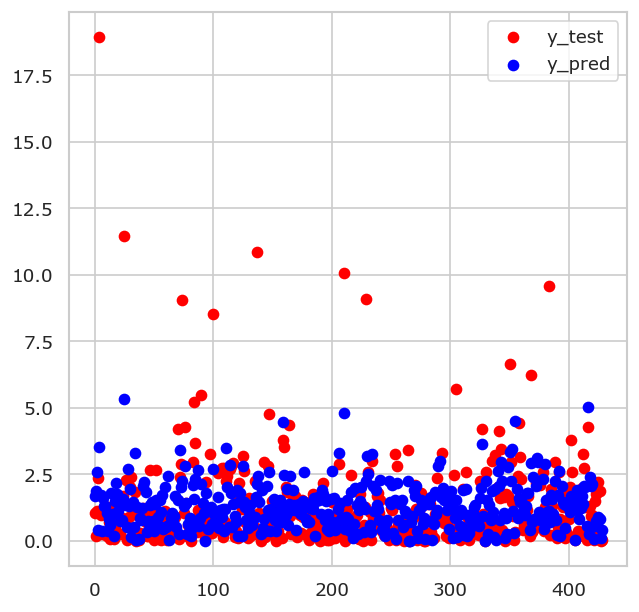

In [167]:
figure = plt.figure(figsize=(6, 6), dpi=120)
subplot = figure.add_subplot()

subplot.scatter(x=np.arange(len(y_test)), y=y_test, c="red", label="y_test")
subplot.scatter(x=np.arange(len(y_pred)), y=np.abs(y_pred), c="blue", label="y_pred")

plt.legend()
plt.show()


# Total Number of Bad Sessions